# Placemaker

Creating a reasonably-functional geodatabase for a place shouldn't require an advanced degree or even a GIS certificate!

Placemaker is a script which allows you to simply specify a geographic place name, and then gather a variety of commonly-used spatial layers for that place as live, computable data.

By default, Placemaker extracts the Open Street Map datasets available for an area.  These include roads, waterways, buildings and land use polygons.  Other individual datasets can also be added below.  At simplest, this requires only a publically-accessible geodata source file or web service location.  Options are available to add metadata, and to drop or rename fields upon import. 

To use this notebook on your own data, simply specify your own input geodataset and desired output table name below.  Any geodatatype readable by GeoPandas can be used.  When the file format contains multiple layers, you can specify the internal layer name(s) desired.  By default, all layers in the container are imported.  Source data layers can be zipped and accessed through network URLs pointing to cloud storage such as s3.

One known limitation is that GeoPandas is currently limited to in-memory operations on the machine running this script.  Where possible, use geographic subdivisions to break up huge requests.  For example, rather than to specify the full state of California, you might instead specify the state "-by county" option.  Where even the subdivisions are too large, you can get around this by creating batch-level geopandas dataframes in a loop, and then importing them to OmniSci using an append operation.

#### How It Works

This tool makes extensive use of a set of other open source tools and data, noteably Geoff Boeing's brilliant OSMNX library, and the Open Street Map community's crowd-sourced planetary data.

For users interested in customization and extension, this notebook shows how to import data from files to GeoPandas to OmniSci.  GeoPandas is a leading open source geospatial library which allows data workflows to and from most geospatial data formats, including a number of cases not handled by OmniSci directly such as ESRI File Geodatabases and GeoPackages.

In [ ]:
%run omnigeo.ipynb

Using pymapd version 0.5.1
Trying to connect to OmniSci
Cannot connect to OmniSci database


### Specify a Place (and optional prefix)

In [ ]:
# enter geographic name or address below
# (can be a place name fragment)
osm_search_text = "Paradise, California" 

# alternative form: can be a dictionary with OSM geographic type fields
#osm_search_text = "{'city':'City of Cambridge', 'state':'Massachusets'}"

# optional short name varient or abbreviation, should be URL-safe
# (this plus underscore will be table name prefix in SQL)
# (leave blank for auto-prefix, which can be a bit verbose)
placename_prefix = "" # "Prov" 

In [ ]:
import osmnx as ox
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

place_gdf = ox.gdf_from_place(osm_search_text,  which_result=1)

To double check:  you want to make sure you got the place intended here, and also that you got the geometry type intended (point for addresses or places to be buffered, polygons in most other cases)

In [ ]:
havePlace = False
if place_gdf.shape[0] == 0:
    print('No place found - try again!')
else:
    havePlace = True
place_gdf

In [ ]:
place_gdf.set_geometry('geometry')

In [ ]:
def isPolygonal(gdf):
    # check geometry type
    if not havePlace:
        return(None)
    geom_type = place_gdf.geom_type[0]
    if geom_type == 'MultiPolygon' or geom_type == 'Polygon':
        return(True)
    else:
        return(False)

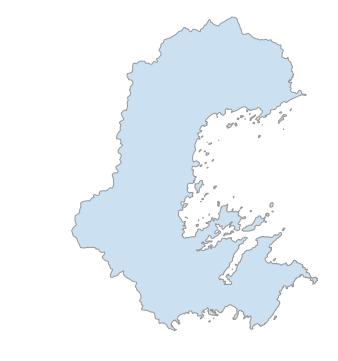

In [7]:
if havePlace and isPolygonal(place_gdf):
    ox.plot_shape(ox.project_gdf(place_gdf))
else:
    print('Warning: Expect place to have polygonal geometry (either intrinsically or by buffering)')

In [ ]:
if havePlace:
    osm_place_name = place_gdf['place_name'].loc[0]
    print(osm_place_name)

In [ ]:
if len(placename_prefix) == 0:
    placename_prefix = osm_place_name.split(',')[0].replace(' ','-').replace(',','-') # to guarantee unique table names on server
    print("Place prefix default is: '{}'".format(placename_prefix))
    print(' override in settings above to shorten or alter if desired')
else:
    print('Using user-specified prefix "{}"'.format(placename_prefix))

In [ ]:
place_bounds_geom = place_gdf.geometry[0]
place_bounds_geom

#### PyMapD Setup Routines

In [ ]:
import pandas as pd
import timeit
import glob
from shapely.geometry import Point, LineString, Polygon

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from pymapd import connect

In [ ]:
import os
MAPD_STORAGE = %env MAPD_STORAGE
MAPD_ERROR_LOG = os.path.join(MAPD_STORAGE,'data/mapd_log/mapd_server.ERROR')

In [ ]:
# connect to mapd default database
def db_connect():
    try:
        con = connect(port=6273, user="mapd", password="HyperInteractive!", host='localhost', dbname="mapd")
    except:
        print('Connection failed')
    return con
db_connect()

In [ ]:
import sys,traceback
con = db_connect()

def mapdql(query):
    if con is None: # refresh if needed
        print('Connection bad or stale')
        return
    try:
        print('Executing query: {}'.format(query))
        results = con.execute(query)
        return results
    except:
        print('Exception executing query')
        a,b,c = sys.exc_info()
        for d in traceback.format_exception(a,b,c) :
           print (d)
        print('last line of Mapd Server Error log reads:')
        !tail -1 {MAPD_ERROR_LOG}
        return None

#### Required Transformations

Create a WKT column for OmniSci's row-wise importer.<br>
This could be a lambda function, but for readability separated here

In [ ]:
def row2wkt(g):
    # g is the geometry cell value, which for geopandas is a shapely binary geometry
    return(g.to_wkt())

In [ ]:
def ddl_from_cols(gdf, geotype):
    print('ddl_from_cols: Geometry type is "{}"'.format(geotype))
    cols = gdf.columns
    # by asking geopandas to infer_objects, we have it guess what it can
    # anything it cannot guess remains an "object" which we default to text encoded dictionary
    gdf = gdf.iloc[1:].infer_objects()
    type_list = gdf.dtypes
    ddl_str = '('
    colno = 0
    for c in cols:
        coltype = type_list[colno]
        #print('Column {} - "{}": type is "{}"'.format(colno, c, coltype))

        if coltype == 'int32':
            ddl_str += '{} INTEGER,'.format(c)
        elif coltype == 'int64':
            ddl_str += '{} BIGINT,'.format(c)
        elif coltype == 'float32':
            ddl_str += '{} SHORT,'.format(c)
        elif coltype == 'float64':
            ddl_str += '{} DOUBLE,'.format(c)
        elif c == 'geometry' or c == 'omnisci_geo' or c == 'mapd_geo':
            print(' found geometry column {}'.format(c))
            if geotype is "Point":
                print(' of type Point')
                ddl_str += 'omnisci_geo GEOMETRY(POINT, 4326) ENCODING COMPRESSED(32),'.format(c)
            elif geotype is "LineString":
                print(' of type LineString')
                ddl_str += 'omnisci_geo GEOMETRY(LINESTRING, 4326) ENCODING COMPRESSED(32),'.format(c)
            elif geotype is "Polygon" or geotype is "MultiPolygon":
                print(' of type Polygon')
                ddl_str += 'omnisci_geo GEOMETRY(POLYGON, 4326) ENCODING COMPRESSED(32),'.format(c)
            else:
                print(' of type "{}"'.format(geotype))
        else:
            ddl_str += '{} TEXT ENCODING DICT(32),'.format(c)
        colno += 1
    # remove terminal comma
    ddl_str = ddl_str[:-1]
    ddl_str += ')'
    return(ddl_str)

You may want to review this a force any column types for which you are not happy with GeoPandas' type estimate.

OSM contributors are prolific and creative with their tagging, so we want to make systematically-sure that no tags conflict with SQL or OmniSci reserverd words.  The latest version of these can be found here:

https://www.omnisci.com/docs/latest/5_reserved_words.html

In [23]:
%%writefile omnisci_reserved_words.txt
ACCESS
ADD
AMMSC
ASC
CONTINUE
COPY
DASHBOARD
DATABASE
DATETIME
DATE_TRUNC
DESC
EDIT
EDITOR
FIRST
FOUND
GEOGRAPHY
GEOMETRY
IF
ILIKE
LAST
LENGTH
LINESTRING
MULTIPOLYGON
NOW
NULLX
OPTION
POINT
POLYGON
PRIVILEGES
PUBLIC
RENAME
REF
ROLE
ROWID
SCHEMA
SQL
TEMPORARY
TEXT
VIEW
WORK

Overwriting omnisci_reserved_words.txt


In [ ]:
def reserved_words():
    with open('omnisci_reserved_words.txt') as f:
        content = f.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content] 
        return(content)

In [ ]:
def gdf_to_omni(gdf, table_name):
    rows = gdf.shape[0]
    if rows == 0:
        print('Cannot process empty geodataframe')
        return(None)  
    if not isPolygonal(gdf):
        print('Geodataframe must be of type Polygon or Multipolygon')
    try:
        the_type_series = gdf.geom_type
        the_type_list = list(the_type_series)
        geotype = the_type_list[0]
        print('gdf_to_omni: Geometry type is "{}"'.format(geotype))
    except:
        print('problem getting required geodataframe geometry type')
        geotype = None
        return(None)

    # the geometry column is specified by geopandas, and not always = 'geometry'
    geom_col = gdf.geometry.name
    #print('Found geometry column called "{}"'.format(geom_col))
   
    # step 1: check coordinate system, and reproject if necessary to WGS84
    crc_dict = gdf.crs
    crc_str = crc_dict['init']
    # to do: test with no coordinate system defined (refuse?)
    print('Input coordinate system is {}'.format(crc_str))
    if not crc_str == 'epsg:4326':
        print('Coordinates not WGS84, reprojecting...')
        gdf = gdf.to_crs({'init': 'epsg:4326'}) 
        print('  done reprojecting')

    # step 2: check for any reserved characters and words in field names and re-name
    for c in gdf.columns:
        if ':' in c:
            #autoname = c.split(':')[-1] # in osm, interesting unique bit it past the :
            autoname = c.replace(':','_') # more verbose option, but avoids some confusing field names
            try:
                gdf = gdf.rename(columns={'{}'.format(c):'{}'.format(autoname)}) #,inplace=True
                print('  renamed "{}" to "{}"'.format(c,autoname))
            except:
                print('Problem renaming column with reserved characters in its name')

    
    for c in gdf.columns:
        if c == 'geometry':
            continue # handled in next step
        for r in reserved_words():
            if c.upper() == r.upper():
                autoname = c + '_' # guaranteed by spec to not be sql reserved name
                print('Warning: found reserved column name "{}" - renaming to "{}"'.format(r,autoname))
                try:
                    gdf = gdf.rename(columns={'{}'.format(c):'{}'.format(autoname)}) #,inplace=True
                except:
                    print('Problem renaming reserved column')
    
    
    # step 3: generate WKT string column
    #print('Generating well-known text for geometries')
    gdf[geom_col] =  gdf[geom_col].map(row2wkt) # try inplace
    try:
        # whatever it starts with, we want to standardize it in omnisci
        print('Renaming geo column to omnisci_geo')
        gdf.rename(columns={'{}'.format(geom_col):'omnisci_geo'},inplace=True) # expected default geo column name in OmniSci
    except:
        print('Problem renaming geopandas columns')
    #print('  done with wkt')
    
    # step 4: create a data schema for this data
    ddl_str = ddl_from_cols(gdf, geotype)
    #print('DDL is: {}'.format(ddl_str))
    
    # step 5: create an empty table, over-writing prior if necessary
    omnitables = con.get_tables()
    if table_name in omnitables:
        print('Droping prior version of table')
        mapdql('DROP TABLE {}'.format(table_name))
    else:
        print('No prior version of table found')
    print('Creating table {}'.format(table_name))
    try:
        q = 'CREATE TABLE {} {}'.format(table_name, ddl_str)
        mapdql(q)
        print("Table created")
    except:
        print('Could not create table - does it already exist?')
        
    # step 6: create row-wise nameless iterator on gdf and import to Omni
    try:
        print('Loading geometry rowwise')
        print('  columns are: {}'.format(str(gdf.columns)))
        con.load_table_rowwise(table_name, gdf.itertuples(index=False, name=None))
        print('  done loading')
        return(True)
    except:
        print('  problem loading')
        a,b,c = sys.exc_info()
        for d in traceback.format_exception(a,b,c) :
           print (d)
        print('last line of Mapd Server Error log reads:')
        !tail -1 {MAPD_ERROR_LOG}

        return(False)

### Save Place Boundaries to OmniSci

In [26]:
# place_bounds_geom.to_wkt()
table_name = placename_prefix + '_bounds'
gdf_to_omni(place_gdf, table_name)

gdf_to_omni: Geometry type is "MultiPolygon"
Input coordinate system is epsg:4326
Renaming geo column to omnisci_geo
ddl_from_cols: Geometry type is "MultiPolygon"
 found geometry column omnisci_geo
 of type Polygon
Droping prior version of table
Executing query: DROP TABLE Paraty_bounds
Creating table Paraty_bounds
Executing query: CREATE TABLE Paraty_bounds (bbox_east DOUBLE,bbox_north DOUBLE,bbox_south DOUBLE,bbox_west DOUBLE,omnisci_geo GEOMETRY(POLYGON, 4326) ENCODING COMPRESSED(32),place_name TEXT ENCODING DICT(32))
Table created
Loading geometry rowwise
  columns are: Index(['bbox_east', 'bbox_north', 'bbox_south', 'bbox_west', 'omnisci_geo',
       'place_name'],
      dtype='object')
  done loading


True

#### Get OSM data for place using OSMNX

In [ ]:
ox.__version__

In [ ]:
print("Starting retrieval of transportation network data for {}".format(osm_place_name))
# optional params
# gdf_name=None, which_result=1, buffer_dist=None
# returns MultiDiGraph
G = ox.graph_from_place(osm_place_name)
print('  done downloading')

In [ ]:
fig, ax = ox.plot_graph(G)

In [ ]:
# need to make line gdf from ox edges graph data structure

In [ ]:
good_edges = []
for data in G.edges(keys=False, data=True):
    featureDict = data[2]
    #print(featureDict)
    try:
        fname = featureDict['name']
    except:
        #print('No name found, defaulting empty name\n')
        fname = ''
        
    try:
        osmid = featureDict['osmid']
        ftype = featureDict['highway']  # osm weirdnesss
    except:
        #print('missing required attributes\n')
        continue
    try:
        geo = featureDict['geometry']
    except:
        #print('skipping link missing required geometry\n')
        continue
    
    #print('nice edge')
    # add to good list
    good_edges.append({'osmid':osmid, 'name':fname, 'ftype': ftype, 'geometry': geo})

try:
    line_gdf = gpd.GeoDataFrame(good_edges)
except:
    print('Problem creating geodataframe from list of dictionaries')

In [ ]:
line_gdf.head(3)

In [ ]:
line_gdf = line_gdf.set_geometry('geometry')

In [ ]:
line_gdf.crs = place_gdf.crs

In [ ]:
table_name = placename_prefix + '_roads'
gdf_to_omni(line_gdf, table_name)

#### Get Buildings

In [ ]:
print("Starting retrieval of buildings data for {}".format(osm_place_name))
place_bld_gdf = ox.buildings_from_place(osm_place_name, retain_invalid=False)

In [ ]:
place_bld_gdf.head(3)

In [ ]:
place_bld_gdf.columns

In [ ]:
'geometry' in place_bld_gdf.columns

In [ ]:
place_bld_gdf = place_bld_gdf.set_geometry('geometry')

In [ ]:
bld_count = place_bld_gdf.shape[0]
print('{} buildings found in OSM dataset'.format(bld_count))

In [ ]:
table_name = placename_prefix + '_buildings'
gdf_to_omni(place_bld_gdf, table_name)

#### Add additional data sources, if desired

These are formatted in python as a list of dictionaries, and persisted on disk as a json file

Two types of sources are recognized: tables and files.  Tables are data already in SQL format on a server.  Files can be local, or remote.  In the case of remote files, the gdal/fiona 'virtual file system' convention is followed.  

Virtual file systems include access methods "http" for web-accessible resources, and "s3" for Amazon storage service buckets.  They can also additionally specify a container type of "zip" for zip compressed archives, or "tar" for unix tape archive format.  Multiple specifiers are separated with a plus sign, and the entire prefix is delimited with a colon.  Thus "zip+http://server.com/path/on/server/to/file/geoarchive.zip" or "zip+s3://bucketname/resource.zip"

In [ ]:
!ls data/*.shp

In [ ]:
%%writefile placemaker_data_sources.json
[
    {
        "type": "file",
        "data_specifier": "waterways.shp",
        "metadata_specifier": ""
    },
    {
        "type": "table",
        "data_specifier": "counties",
        "metadata_specifier": ""
    }
]

In [ ]:
input_file = 'waterways.shp' # with extension
input_folder = '' # can be empty

In [ ]:
# optional settings for compressed archives, remote sources
# ‘http’, ‘s3’, ‘zip+http’, and ‘zip+s3’ are supported
input_virtual_file_system = "zip+s3"
input_server = 'example.com'

### Optional: Use a 3rd Party OSM Extractor

Until OmniSci stands up our own OSM mirror, the script above is sufficient for small areas, but risks overloading OSM community servers for larger jobs.  These are best done for the moment using a 3rd party extractor such as:

In [ ]:
extract_url = 'https://download.bbbike.org/osm/extract/planet_-71.4683,41.7858_-71.3489,41.8584.osm.shp.zip'

In [ ]:
!aria2c --file-allocation=none -c -x 10 -s 10 -d "data" {extract_url}

In [ ]:
!ls data/*.zip

In [ ]:
ziparchive = 'data/' + Path(extract_url).resolve().name
ziparchive

In [ ]:
Path(extract_url).resolve().stem

In [ ]:
!mkdir {placename_prefix}

In [ ]:
# to avoid provider-specific internal naming and pathing conventions...
# -j  junk paths (do not make directories)
# -d  extract files into exdir
# result is a set of shape files in this case, each of which can be independently loaded

!unzip -j -d {placename_prefix} {ziparchive}

In [ ]:
# specific extractor details contribute to actual final path on local dick
# unzip renames .shp to -shp, and archives have internal path with shape folder
!ls {placename_prefix} 

In [ ]:
import glob

filespec = '{}/*.shp'.format(placename_prefix)
for shapefile in glob.glob(filespec):
    # going straight into mapd, hoping extracts don't have invalid field names
    basename = Path(shapefile).resolve().name.replace('.shp','')
    fullpath = os.path.abspath(shapefile)
    table_name = placename_prefix + "_" + basename
    mapdql("COPY {} FROM '{}' WITH (GEO='True');".format(table_name, fullpath))
    # load to geodataframe, so that we can apply standard field processing
    # no reprojection should be necessary
    print('Importing {}'.format(shapefile))
print('Done with OSM Imports')

#### Validation

In [ ]:
import os
from pathlib import Path

def validate_local_source(source_spec):
    stem = Path(source_spec).resolve().stem
    input_path = os.path.join(input_folder, input_file)
    if not os.path.exists(input_path):
        print('Could not find specified input file "{}" in folder "{}"'.format(input_file, input_folder))
    else:
        print('Validated that input file exists')

    table_name = placename_prefix + '_' + Path(input_path).resolve().stem # should work even with symbolic links
    print('Input geopandas data source is: {}'.format(input_file))
    print("Output OmniSci table will be '{}'".format(table_name))
    extension = Path(input_path).resolve().suffix # plural for list of all suffixes
    if extension == '.zip':
        print('Zip file detected, using zip access virtual file system')
        input_path = 'zip:' + input_path
    else:
        print('Extension detected: {}'.format(extension))

URL validation

In [ ]:
import fiona

drivers = fiona.supported_drivers
print('The following drivers are available in your version ({}) of fiona'.format(fiona.__version__))
for d in drivers:
    print(d)

In [ ]:
import geopandas as gpd

# read geo file into geopandas dataframe
gdf = gpd.read_file(input_path)

In [ ]:
gdf.head(3)

In [ ]:
result = gdf_to_omni(gdf)

In [ ]:
con.get_table_details(table_name)

In [ ]:
result_cur = mapdql('SELECT COUNT(*) FROM {}'.format(table_name))

In [ ]:
features = result_cur.fetchone()[0]
print('Table on server has {} features'.format(features))

In [ ]:
if features == gdf.shape[0]:
    print('That seems correct, you should be good to go!')
else:
    print('Potential problem: feature count on server does not match source, try again')